# Tutorial analisi spettri e correlazioni

## Introduzione
Questo quaderno si inserisce nel materiale didattico che verrà fornito agli studenti del secondo modulo del corso di laboratorio di fisica 3A (per gli amici Labo 4).

Abbiamo deciso di iniziare analizzando lo spettro del $^{226}$Ra, che è uno degli esempi più delicati e completi con cui avrete a che fare.

Nel caso durante il corso nascessero esigenze particolari riguardo a qualche dubbio nell'effettuare una certa procedura, oppure vi trovaste a dover lavorare con dati in formati strani, esattamente come durante lo scorso semestre, potete contattarmi e d'accordo con gli altri tutor e con i docenti, vedrò di venirvi incontro nel miglior modo possibile. La mia mail è [scarsi@studenti.uninsubria.it](mailto:scarsi@studenti.uninsubria.it)

## Scopo
In questo quaderno verranno presentati alcuni spunti necessari per poter costruire **istogrammi** relativi a **spettri**, fittarne i picchi e costruire **istogrammi bidimensionali** per studiare le correlazioni.

Il dataset utilizzato uno di quelli relativi all'analisi della *spettroscopia gamma*, ma le medesime tecniche si applicano ad un generico contesto in cui si hanno dei rivelatori da cui, sotto certe condizioni di trigger, viene estratto il massimo della waveform e si deve valutare la distribuzione dei massimi (come per esempio nel contesto della spettroscopia alpha).

## Strumenti
L'analisi viene effettuata utilizzando `Python 3` ed in particolare  moduli `numpy`, `matplotlib`  e `scipy` per la gestione e la visualizzazione di dati numerici.

## Setup sperimentale e contesto
Il setup sperimentale è costituito da due tubi fotomoltiplicatori (PMT) connessi ad una catena elettronica di amplificazione e shaping. Ogni qualvolta almeno uno dei due PMT è sopra una soglia prestabilita, vengono acquisiti i *massimi delle forme d'onda* di ciascun canale.

![](./setup.jpg)
![](./setup2.jpg)

<!-- Un'altra possibilità su cui siamo al lavoro proprio di questi tempo è di acquisire direttamente il segnale proveniente dai PMT ed effettuare la parte di amplificazione, shaping e ricerca del massimo via software. Nella parte superiore si vede il segnale originario relativo ad un LaBr$_3$, mentre nella parte inferiore il segnale shapeato, su cui andare a ricercare il massimo.
![](./wfana.jpg) -->

Potrebbe essere utile avere qualche informazione sul discriminatore...  
![](./insulab-discri-info.png)


## Formato dei dati
I dati sono dei files di testo (in formato ASCII): ogni riga corrisponde ad un evento (ovvero ogni volta che almeno uno dei due PMT ha avuto valore sopra soglia), mentre ogni colonna contiene una certa quantità. Aprendo un file, esso ha la forma

```
...
001480064955 591 87 66 106 
001480064955 130 6 4095 69 
001480064955 235 92 66 106 
001480064955 304 90 66 106 
001480064955 858 87 66 107 
001480064955 257 90 66 106 
001480064955 249 84 66 106 
001480064955 3717 85 68 106 
001480064955 2498 75 69 107 
...
```


dove la prima colonna rappresenta il [tempo unix](https://it.wikipedia.org/wiki/Tempo_(Unix)) (ovvero il numero di secondi trascorsi dalla mezzanotte del 1° Gennaio 1970) mentre le successive quattro colonne rappresentano il massimo del segnale per ciascun canale. I due PMT sono connessi ai primi due canali. Poiché l'analisi è perfettamente equivalente, noi ci soffermeremo solamente sul primo canale.


## Analisi dei dati
Iniziamo caricando (`import`) i moduli che verranno utulizzati durante l'analisi e definendo un alias per comodità nel richiamarli.

In [65]:
# Codice per caricare i moduli necessari

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit


# Questa variabile può essere comoda per decidere se salvare o meno i plot che si vanno a creare
Export = False

## Load dei dati

Carichiamo [i dati](./run020752.dat) utilizzando il metodo `np.loadtxt`. Il carattere "_", pur essendo un nome lecito per una variabile, viene convenzionalmente utilizzato per indicare una variabile di nessuna importanza. Infatti per caricare una matrice con N colonne ed utilizzare l'opzione `unpack=True` (che permette di memorizzare ciascuna colonna in un diverso vettore) è necessario passare tante variabili quante sono le colonne, indipendentemente dal fatto che alcune non sono interessanti.


In [66]:
# Codice per caricare i dati

dati = np.loadtxt("run020752.dat")

# un'altra possibilità, considerato che ci serve solamente la seconda colonna, sarebbe potuta essere
_, datiVect, _, _, _ = np.loadtxt("run020752.dat", unpack = True)

Possiamo subito vedere che forma abbiano i dati caricati

In [67]:
# Codice per visualizzare schematicamente informazioni sui dati

print(dati.shape, dati)
print("------------")
print(datiVect.shape, datiVect)

(200001, 5) [[1.48006496e+09 5.91000000e+02 8.70000000e+01 6.60000000e+01
  1.06000000e+02]
 [1.48006496e+09 1.30000000e+02 6.00000000e+00 4.09500000e+03
  6.90000000e+01]
 [1.48006496e+09 2.35000000e+02 9.20000000e+01 6.60000000e+01
  1.06000000e+02]
 ...
 [1.48006518e+09 1.25800000e+03 8.50000000e+01 6.70000000e+01
  1.07000000e+02]
 [1.48006518e+09 2.75000000e+02 8.70000000e+01 6.50000000e+01
  1.06000000e+02]
 [1.48006518e+09 1.75300000e+03 8.60000000e+01 6.80000000e+01
  1.07000000e+02]]
------------
(200001,) [ 591.  130.  235. ... 1258.  275. 1753.]


## Visualizzazione dei dati
La prima cosa da fare quando si hanno dei dati è sicuramente guardarli. Uno potrebbe essere tentato di plottarli direttamente

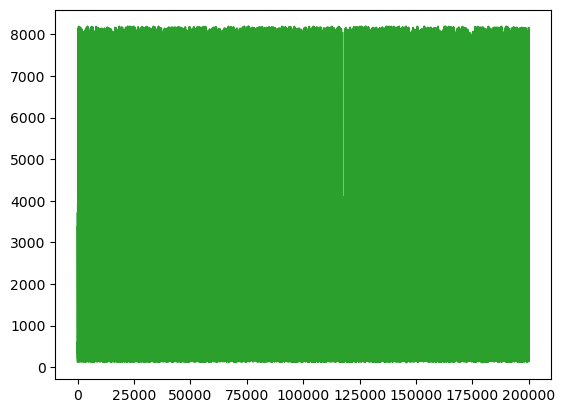

In [68]:
plt.plot(datiVect, c = "tab:green")
plt.show()

Ma purtroppo non si vede un granchè. Possiamo provare a plottare singoli punti non uniti da linee, eventualmente con marker più picolo

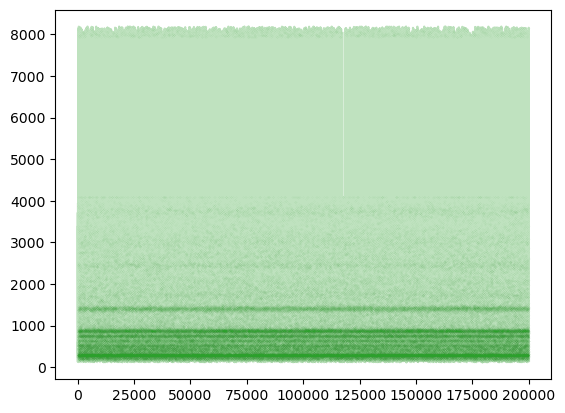

In [69]:
plt.plot(datiVect, c = "tab:green", marker='.', alpha=0.3, ms = .1)
plt.show()

Il problema risiede nel fatto che questi dati non sono da guardare in questo modo

## Costruzione degli spettri
A noi infatti interessa studiare la **distribuzione dei massimi**, sapere in un certo intervallo di valori quanti eventi sono stati registrati: dobbiamo costruire un **istogramma**

`Matplotlib` mette a disposizione il metodo `hist` che permette di effettuare l'istogramma di un vettore

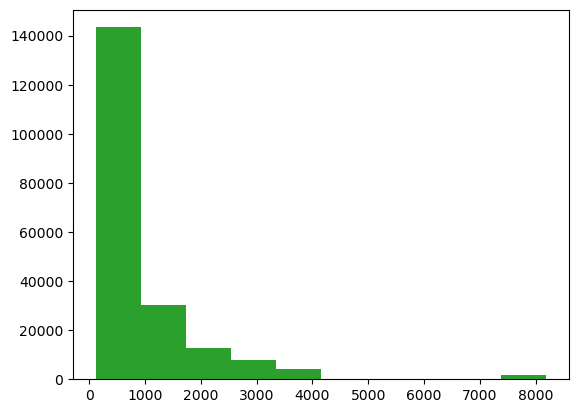

In [70]:
plt.hist(datiVect, fc = "tab:green")
plt.show()

Da questo istogramma si vede poco e nulla. Proviamo ad aumentare il numero di bin

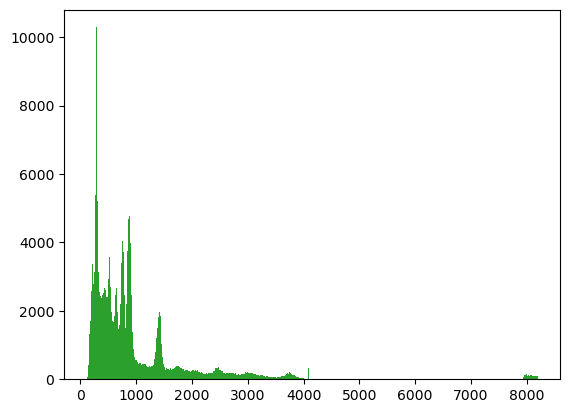

In [71]:
plt.hist(datiVect, bins = 500, fc = "tab:green")
plt.show()

C'è ancora un po' da lavorare per ottenere un bello spettro, anche se qualcosa già si inizia ad intravedere. Vi segnalo che anche `numpy` consente di effettuare istogrammi. Personalmente preferisco mantenere distinta la parte in cui vado a costruire l'istogramma e la parte in cui vado a plottare l'istogramma costruito, pertanto di seguito tutti gli istogrammi saranno creati con il metodo `np.histogram`.

Notiamo come i due metodi ([matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) e [numpy](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)) accettino gli stessi argomenti, ad eccezione dei parametri relativi alla grafica. Infatti il metodo di matplotlib va a richiamare proprio quello di numpy.




## Istogrammi 1D e spettri
Il metodo `np.histogram` accetta come argomento obbligatorio il dataset da istogrammare. Possiamo poi specificargli alcuni parametri opzionali, come per esempio il *numero di bin* o il *range*. Gli argomenti che ritorna invece sono il numero di eventi per ciascun bin e il bordo dei bin.

Il secondo vettore ha un elemento in più del primo e, per ottenere le coordinate $xy$ da plottare, è necessario sfasare tutti i punti, ad eccezione dell'ultimo, di mezzo bin.

Quando devo disegnare più curve in uno stesso plot con impostazioni analoghe, per comodità definisco un dizionario che le contiene e le passo alla funzione `plt.plot` effettuando l'*unpacking dei dizionari* mediante il doppio asterisco.

Per poter disegnare un istogramma con il metodo `plt.plot` è necessario specificare l'opzione `drawstyle` (o la sua abbreviazione `ds`) a `steps-mid`, che indica di tracciare il grafico a gradini e che il gradino debba essere centrato rispetto alla corrispondente ascissa.

In [72]:
# Codice per costruire l'istogramma

h, bins = np.histogram(dati[:,1], bins = 1000)

binc = bins[:-1] + (bins[1] - bins[0])/2

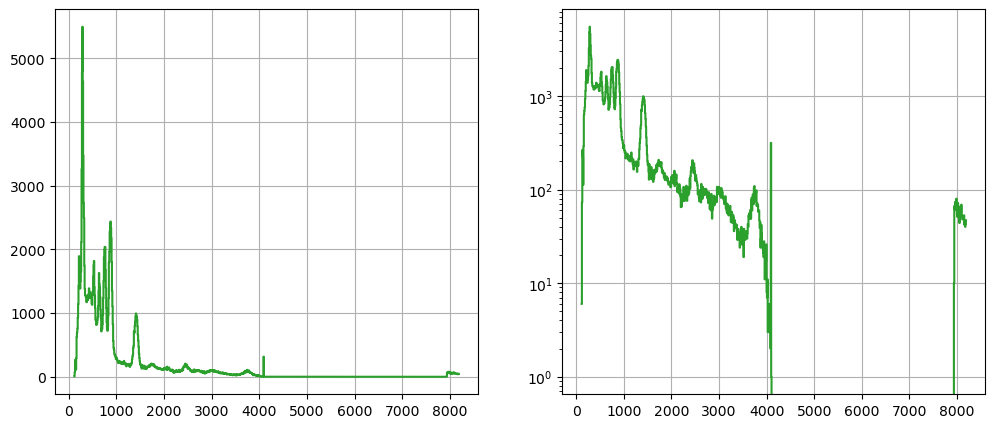

In [73]:
# Alcune prove sbagliate, comode da avere
"""
Notiamo in particolare l'importanza di guardare il grafico con asse y logaritmico 
e di effettuare un taglio sul valore massimo: l'ADC può avere come valore massimo
4096 (è a 12 bit ==> Nmax = 2^12 = 4096, tutti i valori al di sopra di tale soglia 
non hanno significato fisico, sono fluttuazioni o saturazione
"""


fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)
ax[0].plot(binc, h, ds = "steps-mid", c = "tab:green" )
ax[1].plot(binc, h, ds = "steps-mid", c = "tab:green" )

ax[1].set_yscale("log")

for i in ax:
    i.grid(True)


plt.show()

Da questo istogramma si vede poco e nulla. Prima di tutto, poiché l'ADC, ovvero lo strumento che campiona la forma d'onda ha una risoluzione a 12 bit, il maggior numero che ci può restituire è $2^{12}-1=4095$, ed al di sopra potrebbe esserci una saturazione. Abbiamo anche provato a mettere l'asse $y$ in scala logaritmica (`ax.set_yscale("log")`)

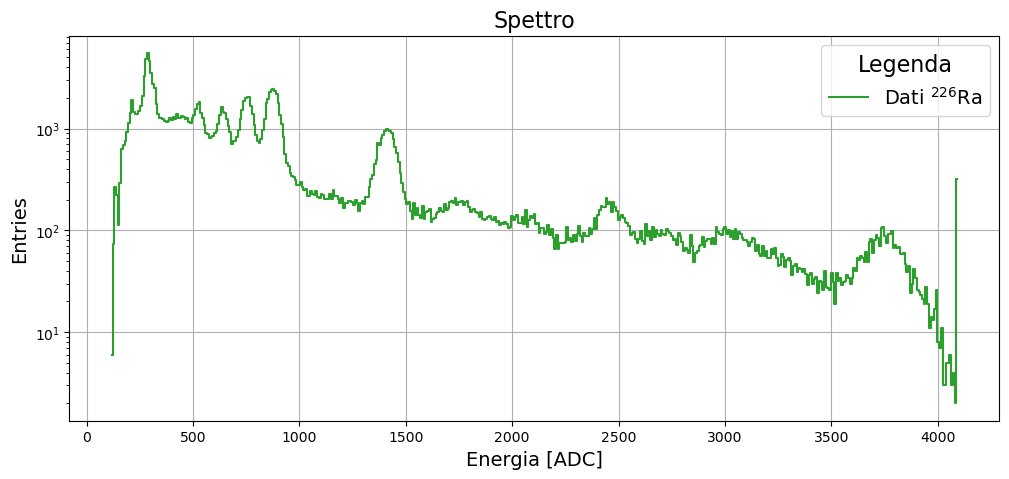

In [74]:
# Codice per visualizzare l'istogramma

cond = binc<4096

fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(binc[cond], h[cond], ds = "steps-mid", c = "tab:green", label = "Dati $^{226}$Ra" )

ax.set_title("Spettro", fontsize = 16)
ax.set_xlabel("Energia [ADC]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)

ax.grid(True)
ax.set_yscale("log")
ax.legend(fontsize = 14, title = "Legenda", loc = "upper right", title_fontproperties = {"size":16})

plt.show()


Una riflessione finale:
Abbiamo fatto il taglio sull'istogramma già costruito, in poche parole visualizziamo solamente una porzione
dell'istogramma costruito. Poiché ci sono fondati motivi teorici per fissare un limite massimo, sarebbe buona
norma mettere il range sull'istogramma da costruire.
In questo esempio ho aggirato il problema facendo mooolti bin

### Versione corretta

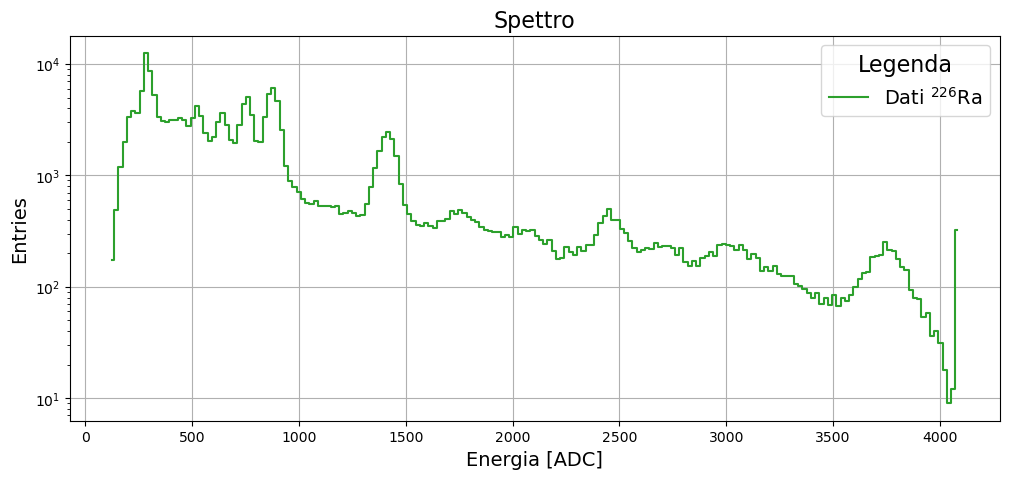

In [75]:
DATI = dati[:,1][dati[:,1] < 4096]

h, bins = np.histogram(DATI, bins = 200)

binc = bins[:-1] + (bins[1] - bins[0])/2


fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(binc, h, ds = "steps-mid", c = "tab:green", label = "Dati $^{226}$Ra" )

ax.set_title("Spettro", fontsize = 16)
ax.set_xlabel("Energia [ADC]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)

ax.grid(True)
ax.set_yscale("log")
ax.legend(fontsize = 14, title = "Legenda", loc = "upper right", title_fontproperties = {"size":16})

if Export:
    plt.savefig("../RELAZIONE/FIGURE/miaImmagine.eps", format = "eps")
plt.show()

Et voilà! Ecco il nostro spettro!

Che cosa mostra questo plot? Questo plot ci mostra la distribuzione del massimo misurato da un PMT, ovvero ci dice in ogni intervallo di energie (misurate in unità arbitrarie di ADC) quanti eventi sono stati registrati. L'area sottesa a questo grafico è invece il numero totale di eventi utilizzati.

Da questo plot si vedono emergere alcuni picchi, che dovrebbero corrispondere ai fotoni che vengono emessi.

## Fit dei picchi

Una volta costruito l'istogramma, vogliamo effettuare il fit dei picchi: in particolare vogliamo trovare la $x$ del massimo e il corrispondente errore: effettuiamo quindi il fit con una funzione gaussiana.

Notare in particolare come i picchi non siano centrati sullo 0 ma abbiano un offset verticale: per tenerne conto possiamo sommare un polinomio di primo grado oppure un esponenziale decrescente. Se il passaggio precedente è stato effettuato correttamente può sembrare che siano montati su una retta decrescente: attenzione a non farsi ingannare dalle impostazioni degli assi.

I picchi da fittare sono i primi 7, che hanno energie 77, 185, 241, 295, 351, 609 e 1120 keV. (Il secondo picco nell'immagine sottostante compare a 186/187, nel logbook fornito era dato a 185. In ogni caso non fa tutta sta gran differenza...)

![](./226Ra.jpg)

Si tratta di fit un po' delicati da far convergere, serve un po' di pazienza: per aiutarsi a stimare gli starting points può essere utile ricorrere al seguente magic command `%matplotlib qt` che consente di aprire il plot in una finestra grafica esterna, e dove muovendosi col puntatore si possono visualizzare le coordinate. Per visualizzare i plot nel modo usuale, esiste il magic command `%matplotlib inline`. 

Per comodità ho definito una funzione che mi aiuta a mantenermi compatto il codice, in modo tale che se facessi anche sono una picoola modifica, non debba propagarla per 7 volte, una per ciascun picco.

Notiamo in particolare come il parametro `absolute_sigma = True` permetta di utilizzare nel fit gli **errori veri** e non degli errori riscalati di un certo fattore tale per cui il $\bar\chi^2\approx 1$

In [76]:
# Definiamo la funzione di fit

"""
Quando si guarda un plot ylog, gli esponenziali vengono trasformati in rette: per tener conto del 
fondo che decresce linearmente, sommiamo alla gaussiana del picco un esponenziale decrescente
"""

def funcToFit(x, a, mu, sigma, b, c):
    return (a/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2*sigma**2))) + (b * np.exp(-c*x))

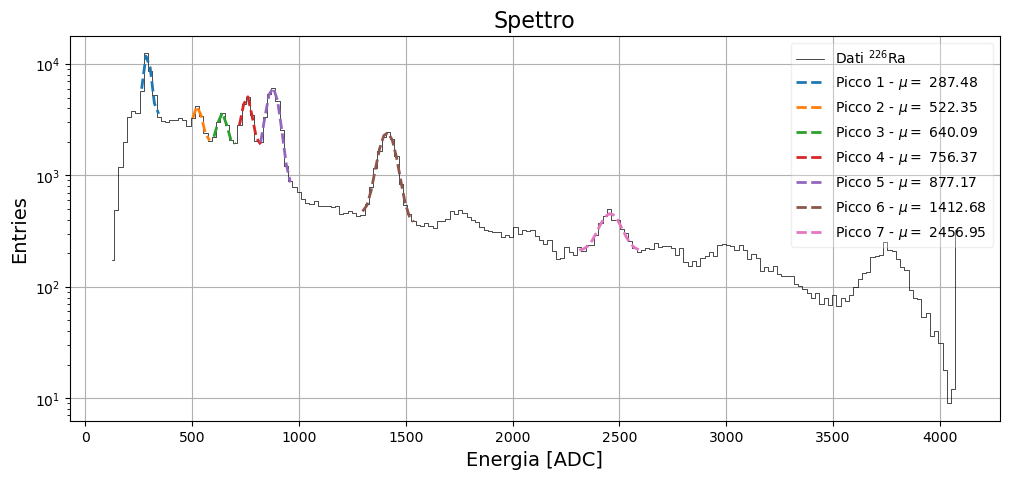

In [77]:
# Codice per fare i fit

# Utile se vogliamo visualizare in una finestra i picchi per stimare i punti
# %matplotlib qt

energieVere = np.array((77, 185, 241, 295, 351, 609, 1120))

# Alcuni parametri per il fit
# -----------0 ----------1 -----------2 ----------3 ----------4 ----------5 -------------6 -------
myRange = ((260, 358), (492, 590), (590, 704), (704, 825), (806, 971), (1296, 1556), (2305, 2600))
startPars = ((3.14020187e+05, 2.98589322e+02, 1.43257226e+01),
             (9.41411082e+04, 5.34214983e+02, 2.02581202e+01),
             (1.04459955e+05, 6.51821651e+02, 2.23514168e+01),
             (2.30961972e+05, 7.65474019e+02, 2.49634128e+01),
             (3.65195534e+05, 8.86502718e+02, 2.82249031e+01),
             (.215e5, 1422, 41.2),
             (9.82593192e+04, 2.47588684e+03, 1.06711679e+02),)

# Inizializzo due liste in cui vado a memorizzare i parametri estratti dal fit
lstPopt = []
lstPcov = []
           
  
# Definisco una funzione comoda per poter raggruppare le stesse operazioni da effettuare varie volte
def myFun(axx, idx):
    
    # Seleziono il range in cui fare il fit
    tmpCond = (binc > myRange[idx][0]) & (binc < myRange[idx][1])
    
    # Definisco gli starting points
    tmpp0 = (*startPars[idx], 7.81582354e+03, 2.32745796e-03)
    
    # Effettuo il fit
    popt, pcov = curve_fit(funcToFit, binc[tmpCond], h[tmpCond], p0 = tmpp0, 
                           sigma = np.sqrt(h[tmpCond]), absolute_sigma = True)
    
    # Memorizzo i parametri
    lstPopt.append(popt)
    lstPcov.append(pcov)
          
        
    # Plotto le curve fittate    
    #axx.plot(binc[tmpCond], funcToFit(binc[tmpCond], *tmpp0), ls = ":", c = "r")
    axx.plot(binc[tmpCond], funcToFit(binc[tmpCond], *popt), ls = "--", lw = 2,
             label = f"Picco {idx+1} - $\mu=$ {popt[1]:.2f}")
            
           

            
# Rifaccio il plot dell'istogramma definito nella cella precedente
fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(binc, h, ds = "steps-mid", c = "k", label = "Dati $^{226}$Ra", lw= .5 )


                           
# Vao a richiamare la funzione per ciascun picco  
for i in range(7): myFun(ax, i)                          
                           
                           
# Alcune impostazioni grafiche del plot                           
ax.set_title("Spettro", fontsize = 16)
ax.set_xlabel("Energia [ADC]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)

ax.grid(True)
ax.set_yscale("log")
ax.legend(fontsize = 10, framealpha = .3)

plt.show()

## GUI for autofit
Qualcuno potrebbe pensare che io sia un pazzo ad aver stimato a mano con precisione fino alla n cifra decimale gli starting points. In realtà mi sono servito di uno strumento [molto comodo](https://pypi.org/project/dataphile/) che ho leggermente customizzato e che permette in modo visuale di aggiustare a mano i parametri di fit. In particolare, rispetto alla versione disponibile online, ho aggiunto la possibilità di passare errori al fit (cosa di vitale importanza per un fisico). 


### Installation info
- In una anaconda power shell, scrivere `pip install dataphile`, o per chi avesse un computer linux, in un qualsiasi terminale
- Recarsi in una cartella analoga a `C:\Users\steca\anaconda3\lib\site-packages\dataphile\statistics\regression`, in particolare a dove è stato installato il modulo `dataphile`, e sostituire il file `modeling.py` con [questa versione](./modeling.py) modificata da me, per poter fare i fit con gli errori senza grossa fatica


### Esempio di utilizzo
Per poter essere dinamico è necessario aprirlo in una finestra grafica esterna (`%matplotlib qt`), mentre in linea (`%matplotlib inline`) viene stampata solo un'immagine statica.

In [78]:
from dataphile.statistics.regression.modeling import Parameter, Model, CompositeModel, AutoGUI


def gauss(x,a,mu,sigma):
    return a/(sigma*np.sqrt(2*np.pi))* np.exp(-(x-mu)**2 / (2*sigma**2)) 

def line(x, m, q):
    return m*x+q

def exp(x,a,k):
    return a*np.exp(-k*x)

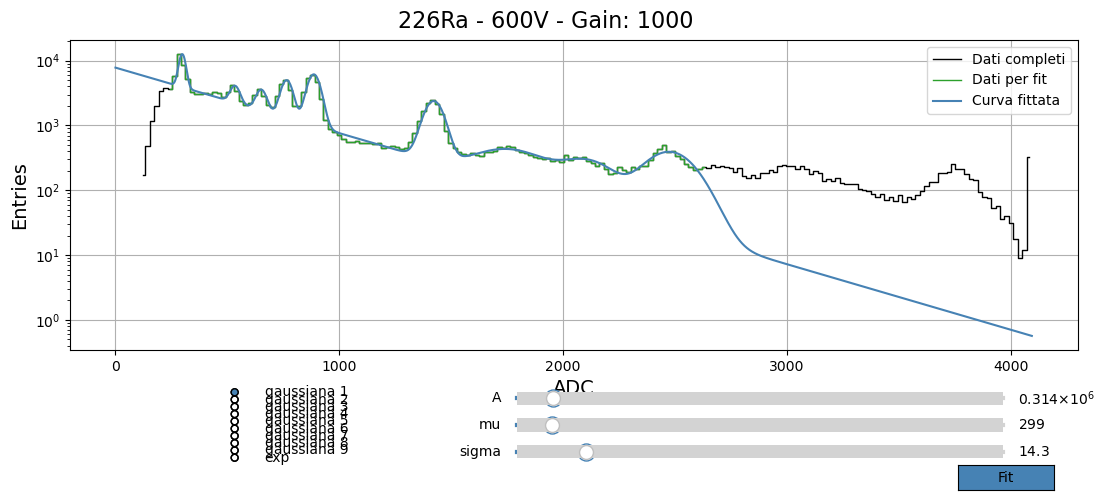

In [79]:
%matplotlib qt
%matplotlib inline
# Creo figura e assi su cui disegnare
fig = plt.figure()
fig.set_size_inches(12,5)
fig.suptitle("226Ra - 600V - Gain: 1000 ", fontsize=16)

ax = fig.add_axes([0.15, 0.14, 0.84, 0.70])
ax.set_yscale("log")
ax.grid(True)
ax.set_xlabel("ADC", fontsize=14)
ax.set_ylabel("Entries", fontsize=14)



# Plotto tutti i dati
ax.plot(binc, h, color='black', lw=1, label='Dati completi', ds="steps-mid")


# Seleziono e Plotto i dati da fittare
cond = (binc<2633) & (binc>243)
xVect = binc[cond]
yVect = h[cond]

data_graph, = ax.plot(xVect, yVect, lw=1, label='Dati per fit',\
                      ds="steps-mid", c="tab:green")


    
# Starting points: inseriti copiando quelli di convergenza
startPars = np.array([
       3.14020187e+05, 2.98589322e+02, 1.43257226e+01, 
       9.41411082e+04, 5.34214983e+02, 2.02581202e+01, 
       1.04459955e+05, 6.51821651e+02, 2.23514168e+01, 
       
       2.30961972e+05, 7.65474019e+02, 2.49634128e+01,
       3.65195534e+05, 8.86502718e+02, 2.82249031e+01, 
       2.14699579e+05, 1.42224403e+03, 4.12398651e+01, 
       
       1.13048417e+05, 1.76150564e+03, 1.49847505e+02,
       6.24648382e+04, 2.11018949e+03, 1.12551885e+02,
       9.82593192e+04, 2.47588684e+03, 1.06711679e+02,
       
       7.81582354e+03, 2.32745796e-03])


# Movello di fitting
model = CompositeModel(
    Model(gauss,
          Parameter(value=startPars[0], bounds=(1e5, 3e6),      label='A'),
          Parameter(value=startPars[1],   bounds=(0, 4095),   label='mu'),
          Parameter(value=startPars[2],   bounds=(0, 100), label='sigma'),
          label='gaussiana 1'),
    Model(gauss,
          Parameter(value=startPars[3], bounds=(1e5, 3e6),      label='A'),
          Parameter(value=startPars[4],   bounds=(0, 4095),   label='mu'),
          Parameter(value=startPars[5],   bounds=(0, 100), label='sigma'),
          label='gaussiana 2'),
    Model(gauss,
          Parameter(value=startPars[6], bounds=(1e5, 3e6),      label='A'),
          Parameter(value=startPars[7],   bounds=(0, 4095),   label='mu'),
          Parameter(value=startPars[8],   bounds=(0, 100), label='sigma'),
          label='gaussiana 3'),
    
    Model(gauss,
          Parameter(value=startPars[9], bounds=(1e5, 3e6),      label='A'),
          Parameter(value=startPars[10],   bounds=(0, 4095),   label='mu'),
          Parameter(value=startPars[11],   bounds=(0, 100), label='sigma'),
          label='gaussiana 4'),
    Model(gauss,
          Parameter(value=startPars[12], bounds=(1e5, 3e6),      label='A'),
          Parameter(value=startPars[13],   bounds=(0, 4095),   label='mu'),
          Parameter(value=startPars[14],   bounds=(0, 100), label='sigma'),
          label='gaussiana 5'),
    Model(gauss,
          Parameter(value=startPars[15], bounds=(1e5, 3e6),      label='A'),
          Parameter(value=startPars[16],   bounds=(0, 4095),   label='mu'),
          Parameter(value=startPars[17],   bounds=(0, 100), label='sigma'),
          label='gaussiana 6'),
    
    Model(gauss,
          Parameter(value=startPars[18], bounds=(1e4, 3e6),      label='A'),
          Parameter(value=startPars[19],   bounds=(0, 4095),   label='mu'),
          Parameter(value=startPars[20],   bounds=(0, 100), label='sigma'),
          label='gaussiana 7'),
    Model(gauss,
          Parameter(value=startPars[21], bounds=(1e4, 3e6),      label='A'),
          Parameter(value=startPars[22],   bounds=(0, 4095),   label='mu'),
          Parameter(value=startPars[23],   bounds=(0, 100), label='sigma'),
          label='gaussiana 8'),
    Model(gauss,
          Parameter(value=startPars[24], bounds=(1e4, 3e6),      label='A'),
          Parameter(value=startPars[25],   bounds=(0, 4095),   label='mu'),
          Parameter(value=startPars[26],   bounds=(0, 100), label='sigma'),
          label='gaussiana 9'),

#    Model(line,
#          Parameter(value=-4.55851, bounds=(-10, 10),  label='m'),
#          Parameter(value=5881.62, bounds=(-100, 10000), label='q'),
#          label='retta'),
    Model(exp,
          Parameter(value=startPars[27], bounds=(0, 1e5),  label='a'),
          Parameter(value=startPars[28], bounds=(0, 1e-2), label='k'),
          label='exp'),
    label='gaussian_peaks')


# Disegno la curva da muovere
xsample = np.linspace(0, 4095, 1500)
model_graph, = ax.plot(xsample, model(xsample), color='steelblue', \
                       label='Curva fittata')
ax.legend();


# Mostro la figura
fig


# Ridimensiono gli assi per fare spazio ai cursori
ax.set_position([0.10, 0.30, 0.84, 0.62])

# Chiamo ciò che fa la magia
gui = AutoGUI(model, [model_graph], bbox=[0.20, 0.07, 0.75, 0.16], figure=fig,
              slider_options={'color': 'steelblue'}, data=(xVect, yVect), 
              sigma=np.sqrt(yVect));

In [80]:
# Ottengo i parametri stimati dopo aver premuto il pulsante "fit"

Riassunto = model.summary()
Riassuntonp = np.array(Riassunto)

Riassunto


value uncertainty
model       parameter                           
gaussiana 1 A          314020.187000        None
            mu            298.589322        None
            sigma          14.325723        None
gaussiana 2 A           94141.108200        None
            mu            534.214983        None
            sigma          20.258120        None
gaussiana 3 A          104459.955000        None
            mu            651.821651        None
            sigma          22.351417        None
gaussiana 4 A          230961.972000        None
            mu            765.474019        None
            sigma          24.963413        None
gaussiana 5 A          365195.534000        None
            mu            886.502718        None
            sigma          28.224903        None
gaussiana 6 A          214699.579000        None
            mu           1422.244030        None
            sigma          41.239865        None
gaussiana 7 A          113048.417000        None
            mu           1761.505640        None
            sigma         149.847505        None
gaussiana 8 A           62464.838200        None
            mu           2110.189490        None
            sigma         112.551885        None
gaussiana 9 A           98259.319200        None
            mu           2475.886840        None
            sigma         106.711679        None
exp         a            7815.823540        None
            k               0.002327        None

## Ottenimento dei valori estratti dal fit

Dopo aver effettuato il fit è importante ottenere i parametri risultanti dal fit, in particolare ci interessa ottenere $\mu$ e $\sigma$ delle gaussiane con i relativi errori. I parametri si trovano direttamente in `popt`, mentre `pcov` costituisce la matrice delle covarianze. Sulla diagonale si trovano le varianze, ovvero il quadrato della deviazione standard.

Inoltre, essendo la gaussiana $$\dfrac{1}{\sigma\,\sqrt{2\pi}}\,e^{-\dfrac{(x-\mu)^2}{2\sigma^2}}$$
normalizzata, ovvero di area unitaria, il prefattore $a$ di  $$\dfrac{a}{\sigma\,\sqrt{2\pi}}\,e^{-\dfrac{(x-\mu)^2}{2\sigma^2}}$$ rappresenta l'area della gaussiana.

Notiamo che nella funzione gaussiana, la "forma" viene data dal secondo termine (l'esponenziale) mentre il prefattore prima è semplicemente una costante. Talvolta (per comodità o per esempio nella parametrizzazione di PAW) la gaussiana viene indicata come $$A\,e^{-\dfrac{(x-\mu)^2}{2\sigma^2}}$$ tale formulazione è assolutamente lecita, in poche parole si è definito $A=\dfrac{a}{\sigma\,\sqrt{2\pi}}$. In questo caso bisogna però stare attenti che il parametro $A$ non rappresenta direttamente l'area.

In [81]:
# Codice per ottenere parametri ed errori

"""
Per ottenerli, trattandosi di solo 7 elementi, posso ciclare. Per compattezza
ho scelto di utilizzare una list comprehension, ovvero una sorta di ciclo for
compatto. Uno avrebbe tranquillamente potuto impostare un ciclo for standard.
"""

lstMu = np.array([i[1] for i in lstPopt])
lstSigma = np.array([i[2] for i in lstPopt])
lstErrMu = np.array([np.sqrt(np.diag(i))[1] for i in lstPcov])
lstErrSigma = np.array([np.sqrt(np.diag(i))[2] for i in lstPcov])

lstArea = np.array([i[0] for i in lstPopt])
lstErrArea = np.array([np.sqrt(np.diag(i))[0] for i in lstPcov])

Siccome io sono pigro, questo è un modo di farsi aiutare dal pitone a formattare le tabelle $\LaTeX $, cosicchè sia sufficiente copiare questo output ed incollarlo nella relazione, senza dover inserire ogni numero a mano.

In [82]:
# Stampo un esempio di tabella latex
for i in range(7):
    print(f"Picco {i+1}\t& Mu: {lstMu[i]:.2f}±{lstErrMu[i]:.2f}\t& Sigma: {lstSigma[i]:.2f} ± {lstErrSigma[i]:.2f}\t& Area: {lstArea[i]:.2f} ± {lstErrArea[i]:.2f} \\\\")

Picco 1	& Mu: 287.48±5642.76	& Sigma: 17.62 ± 10309.14	& Area: 418698.42 ± 498282454.86 \\
Picco 2	& Mu: 522.35±521361.62	& Sigma: 21.24 ± 696747.74	& Area: 123272.27 ± 10386501890.83 \\
Picco 3	& Mu: 640.09±0.86	& Sigma: 18.38 ± 1.11	& Area: 76587.31 ± 6160.32 \\
Picco 4	& Mu: 756.37±0.65	& Sigma: 18.90 ± 0.85	& Area: 143121.94 ± 9088.29 \\
Picco 5	& Mu: 877.17±0.44	& Sigma: 27.89 ± 0.52	& Area: 353261.16 ± 8602.73 \\
Picco 6	& Mu: 1412.68±0.60	& Sigma: 38.18 ± 0.66	& Area: 193796.80 ± 3716.40 \\
Picco 7	& Mu: 2456.95±2.97	& Sigma: 47.31 ± 3.64	& Area: 28795.52 ± 2729.95 \\


## Costruzione della retta di calibrazione

Una volta che sono stati individuati i picchi con il fit gaussiano, è possibile convertire gli spettri da unità arbitrarie di ADC ad energie in keV. Sapendo l'energia vera dei picchi (vedi sopra) ed avendo stabilito i picchi che si vedono quali energie dovrebbero avere, è possibile plottare l'energia in unità di ADC (la $x$ del picco, la $\mu$ estratta dal fit) in funzione dell'energia vera. Questa retta costituisce la retta di calibrazione (più precisamente l'inverso della retta di calibrazione, ovvero quella funzione che accetta come argomento un'energia in ADC e restituisce l'energia in keV. Per stabilire chi mettere sulle $x$ e chi sulle $y$ chiediamoci chi ha errore e chi assumiamo come esatto.

Inizio quindi definendo la funzione di fit. È vero che per una retta esiste la funzione [polifit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html), ma ci sono state delle volte in cui mi ha dato problemi, e comunque non si possono specificare gli errori. 

Successivamente definisco dei vettori contenenti i valori veri dei picchi, i valori estratti dal fit e gli errori.

Procedo quindi effettuando il fit ed andando ad effettuare il plot


In [83]:
# Codice per fittare la retta di calibrazione

# Definisco la funzione di fit
def line(x, m, q):
    return m*x+q

# Effettuo il fit
popt, pcov = curve_fit(line, energieVere, lstMu, sigma = lstSigma, absolute_sigma = True)

# Calcolo il chi2
chi2 = np.sum( ( (line(energieVere, *popt) - lstMu ) / lstSigma)**2 ) / (len(lstMu) - 2)
print(f"Il chi2 ridotto vale {chi2}")

Il chi2 ridotto vale 0.11426215202094855


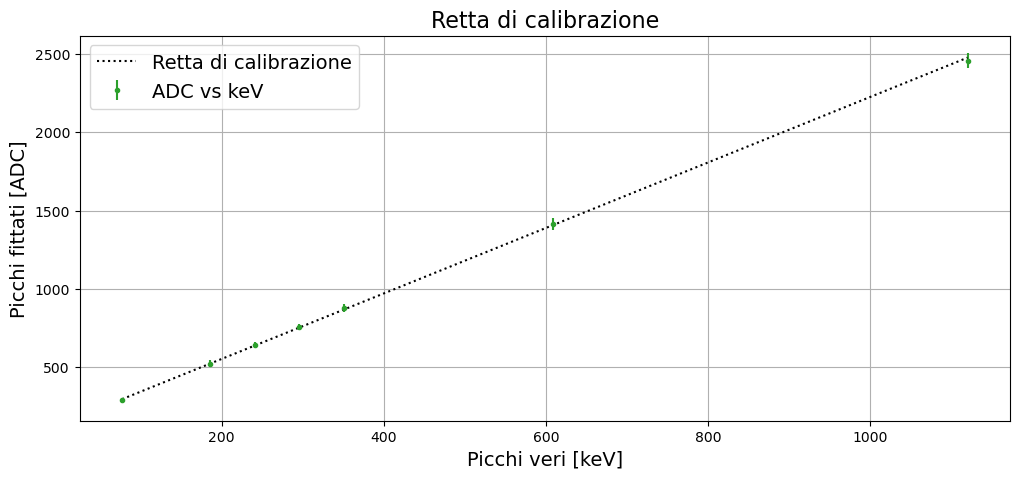

In [84]:
# Codice per plottare la retta di calibrazione

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

ax.errorbar(energieVere, lstMu, yerr = lstSigma, c = "tab:green", marker = ".", ls = "", label = "ADC vs keV")
ax.plot(energieVere, line(energieVere, *popt), c = "k", ls = ":", label = "Retta di calibrazione")

ax.set_title("Retta di calibrazione", fontsize = 16)
ax.set_xlabel("Picchi veri [keV]", fontsize = 14)
ax.set_ylabel("Picchi fittati [ADC]", fontsize = 14)

ax.grid(True)
ax.legend(fontsize = 14)

plt.show()


## Plot dell'istogramma in energia

A questo punto per plottare l'istogramma in energia non ci resta che copiare il codice usato in precedenza, applicando *una certa trasformazione* alle $x$ per ottenere lo spettro della nostra sorgente di $^{226}$Ra.

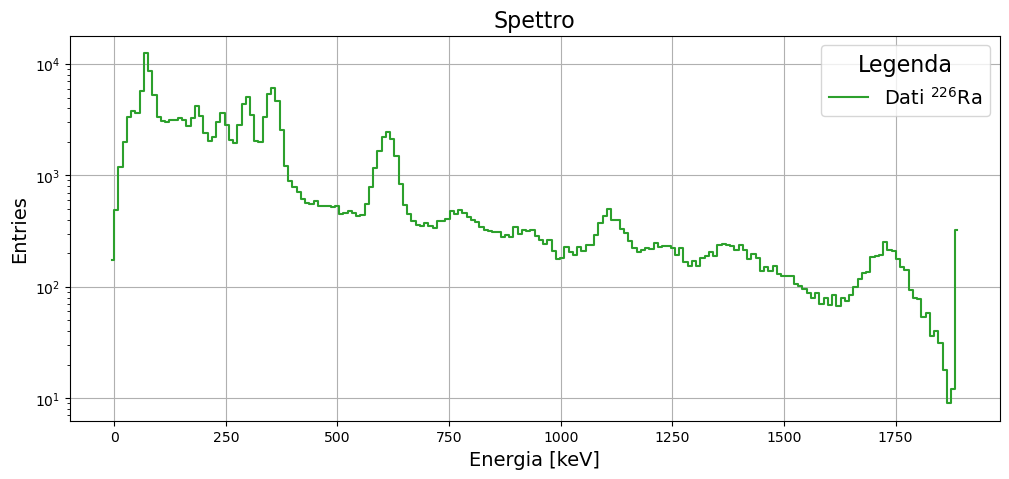

In [85]:
# Codice per plottare l'istogramma in energie

"""
Come già discusso, la retta di calibrazione è quella funzione che consente di passare da ADC a keV.
Quella appena costruita è l'inverso della retta di calibrazione. Fortunatamente le rette sono funzioni
invertibili

y = mx + q -> (y-q)/m = x

Il coefficiente ancolare diventa 1/m, mentre l'intercetta è -q/m
"""

m = 1/popt[0]
q = -popt[1]/popt[0]


# Copiando dallo step 2

h, bins = np.histogram(DATI, bins = 200)

binc = bins[:-1] + (bins[1] - bins[0])/2

# PASSAGGIO NUOVO: CONVERTO I BINC IN KEV
bincInKev = line(binc, m, q)


fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(bincInKev, h, ds = "steps-mid", c = "tab:green", label = "Dati $^{226}$Ra" )

ax.set_title("Spettro", fontsize = 16)
ax.set_xlabel("Energia [keV]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)

ax.grid(True)
ax.set_yscale("log")
ax.legend(fontsize = 14, title = "Legenda", loc = "upper right", title_fontproperties = {"size":16})

plt.show()



Volendo si può colorare tutta l'area al di sotto dello spettro, in modo tale da ottenere un *grafico a barre*. Si tratta di una semplice operazione estetica. Il metodo `plt.fill_between` permette di riempire l'area tra due curve, nel nostro caso tra lo 0 e l'istogramma tracciato.

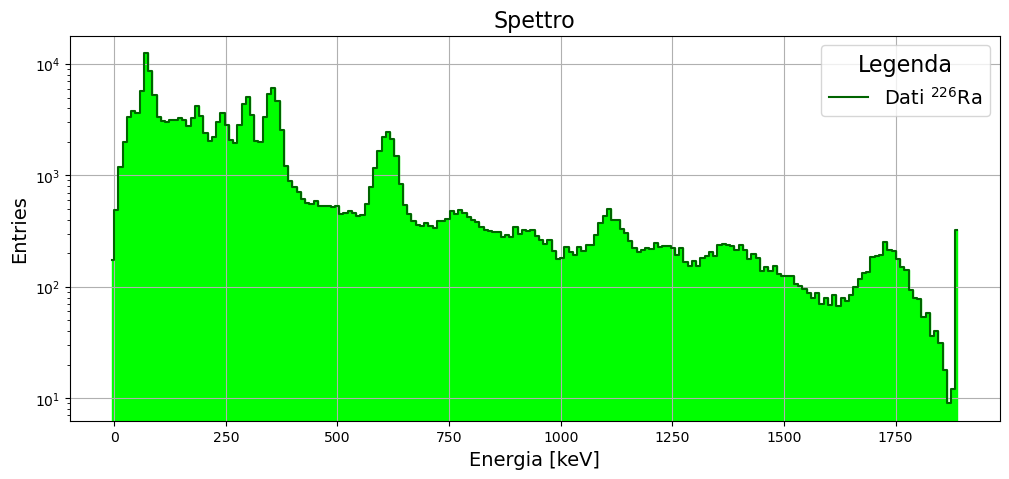

In [86]:
# Codice per plottare l'istogramma in energie

"""
Come già discusso, la retta di calibrazione è quella funzione che consente di passare da ADC a keV.
Quella appena costruita è l'inverso della retta di calibrazione. Fortunatamente le rette sono funzioni
invertibili

y = mx + q -> (y-q)/m = x

Il coefficiente ancolare diventa 1/m, mentre l'intercetta è -q/m
"""

m = 1/popt[0]
q = -popt[1]/popt[0]


# Copiando dallo step 2

h, bins = np.histogram(DATI, bins = 200)

binc = bins[:-1] + (bins[1] - bins[0])/2

# PASSAGGIO NUOVO: CONVERTO I BINC IN KEV
bincInKev = line(binc, m, q)


fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(bincInKev, h, ds = "steps-mid", c = "darkgreen", label = "Dati $^{226}$Ra" )
ax.fill_between(bincInKev, h, step = "mid", color = "lime", alpha = 1)


ax.set_title("Spettro", fontsize = 16)
ax.set_xlabel("Energia [keV]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)

ax.grid(True)
ax.set_yscale("log")
ax.legend(fontsize = 14, title = "Legenda", loc = "upper right", title_fontproperties = {"size":16})

plt.show()



# Pro tip

## Automatic load data (1)
Durante l'attività di spettroscopia gamma acquisirete un file per ogni sorgente: piuttosto che aprire ciascun file salvandosi i dati in differenti variabili, può essere comodo automatizzare la procedura. Per ogni evento vengono salvati due differenti files: uno ".dat" che contiene i dati e uno ".log" che contiene alcune informazioni sull'acquisizione.

In una certa cartella ho due sottocartelle:
- PITONE: contiene gli script python
- DATI: contiene i dati acquisiti
Per automatizzare il tutto potrebbe essere conveniente implementare qualcosa del tipo

```python
# Questa lista contiene le varie matrici di dati, ogni matrice è un file
listaMatrici = []
# Questa lista invece contiene 
listaNum = []

# Ciclo su tutti i files nella cartella dati, indietro di un livello ("..")
for e in os.scandir(r"..\DATI"):
    if e.name.split(".")[1] != "dat": continue

    tmp = np.loadtxt(e.path)
    listaMatrici.append(tmp.copy())
    listaNum.append(int(e.name.split(".")[0][-2:]))
    
zipIt = zip(listaNum, range(len(listaNum)))
# Questo dizionario accetta come input il numero di run (in realtà gli ultimi due numeri) e dà come output l'indice progressivo con cui è stato caricato. Non è automaticamente garantito che i dati vengano caricati in ordine alfabetico
myDict = dict(zipIt)
```

Attenzione! È fodnamentale appendere `tmp.copy()` e non semplicemente `tmp`: nel primo caso si appende un nuovo oggetto per ogni file, mentre nel secondo caso si appende sempre lo stesso oggetto (e quindi tutte le matrici sarebbero uguali all'ultimo file aperto). 



## Automatic load data (2)
Un'altra possibilità non presente nella prima versione, prevede di usare il più versatile modulo [`glob`](https://docs.python.org/3/library/glob.html). Personalmente, ultimamente preferisco questo modo, essendo più versatile. La wildcard `*` vuol dire *qualsiasi sequenza di caratteri*, e che termini con `.dat`, funziona esattamente come un terminale di un sistema Linux.

```python
for f in glob.glob(os.path.join("..\DATI", "*.dat")):
    tmp = np.loadtxt(f)
    ...

```

Oppure, per i fan delle notazioni concise (ANDREBBE VERIFICATO...)  

```python
myDict = {f.split(os.path.sep)[-1].split(".")[0] :  np.loadtxt(f)  for f in glob.glob(os.path.join("..\DATI", "*.dat"))}
```




Per effettuare la procedura di analisi e fit, anziché costruire manualmente plot ed istogrammi per ciascuna sorgente, ho implementato una funzione la cui firma è
```python
def makeFit(numRun, sogliaMin, sogliaMax, startPars, rangeFit, valVero, sorgente,\
            fig, ax, primoPicco = True):
```
che può essere un utile spunto. Ognuno di voi sceglierà comunque la strategia che più ritiene opportuna. In particolare l'opzione `primoPicco` serve a tener conto di sorgenti che abbiano più picchi (come il caso del $^{226}$Ra che abbiamo visto in questa esercitazione.

# Istogrammi bidimensionali

I **biplot** o **istogrammi bidimensionali** possono essere costruiti facilmente sia usando `matplotlib` che `numpy` utilizzando funzioni analoghe. In questo caso utilizziamo il metodo `plt.hist2d`, che accetta come argomenti due vettori, oltre a parametri analoghi al caso monodimensionale (numero di bin, range, ...). Inoltre specifichiamo la [mappa di colore](https://matplotlib.org/stable/tutorials/colors/colormaps.html) che intendiamo utilizzare.

Il biplot effettua un binnaggio lungo i due assi ed in ogni quadratino viene riportato il numero delle volte che il primo canale rientrava in quel bin lungo x ed il secondo canale il quel bin lungo y, ovvero il numero di volte che il primo PMT ha visto una certa energia ed il secondo PMT un'altra certa energia. Il numero di volte viene codificato con un colore.

Questo tipo di plot sono molto potenti in quanto permettono di studiare le correlazioni tra i due canali. Nel nostro caso abbiamo due fotoni che possono venire emessi in coincidenza (a distanza di pochissimo tempo) e venir rivelati uno per ciascun PMT: questo giustifica gli addensamenti che si notano.

Iniziamo quindi a caricare [i dati](./run020252.dat) relativi al $^{22}$Na. In questo caso è necessario utilizzare i dati di entrambi i PMT.

In [87]:

# Carico i dati
_, dati1, dati2, _, _ = np.loadtxt("run020252.dat", unpack = True)

# Converto in keV
dati1 = line(dati1, m, q)
dati2 = line(dati2, m, q)


Costruisco quindi l'istogramma bidimensionale

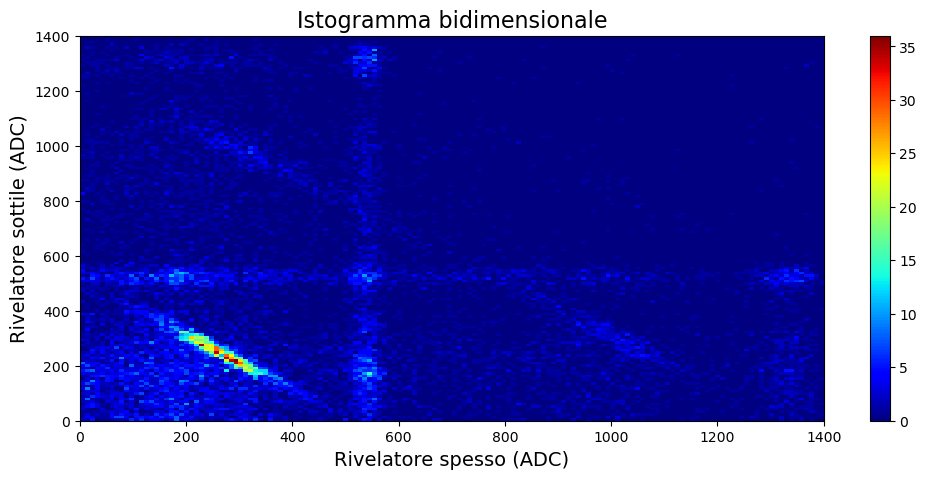

In [88]:
import matplotlib as mpl

fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.set_title("Istogramma bidimensionale", fontsize=16)

myPlot = ax.hist2d(dati1, dati2, bins = (150, 150), range = ((0, 1400), (0, 1400)), 
                   cmap = mpl.cm.jet)

ax.set_xlabel("Rivelatore spesso (ADC)", fontsize = 14)
ax.set_ylabel("Rivelatore sottile (ADC)", fontsize = 14)

fig.colorbar(myPlot[3], ax = ax)


plt.show()

Spesso può essere utile consultare gli istogrammi in scala logaritmica per accentuare piccole differenze. Per farlo è sufficientemente specificare tra gli argomenti `norm = mpl.colors.LogNorm()`

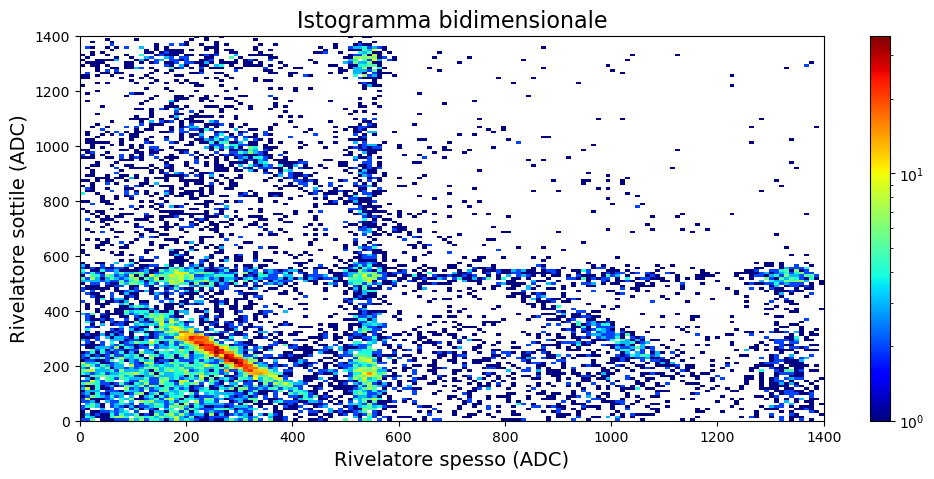

In [89]:

fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.set_title("Istogramma bidimensionale", fontsize=16)

myPlot = ax.hist2d(dati1, dati2, bins = (150, 150), range = ((0, 1400), (0, 1400)),  
                    norm = mpl.colors.LogNorm(), cmap = mpl.cm.jet)

ax.set_xlabel("Rivelatore spesso (ADC)", fontsize = 14)
ax.set_ylabel("Rivelatore sottile (ADC)", fontsize = 14)

fig.colorbar(myPlot[3], ax = ax)


plt.show()

Notiamo che tale grafico ha qualcosa di visualmente fastidioso, in particolare introduce una discontinuità, alternando bianco e blu. Ciò è legato al fatto che dove si ha il bianco si hanno 0 conteggi, il cui logaritmo non è definito. Poiché i nostri dati sono sempre riferiti a conteggi, quindi sono 0, 1, 2.... può essere utile ridefinire a 0 il caso in cui vi siano stati 0 conteggi, mantenendo così l'uniformità. Il modulo `copy` ci permette di copiare un oggetto in modo completo, in modo tale che noi possiamo modificare una versione clonata di un oggetto di libreria.

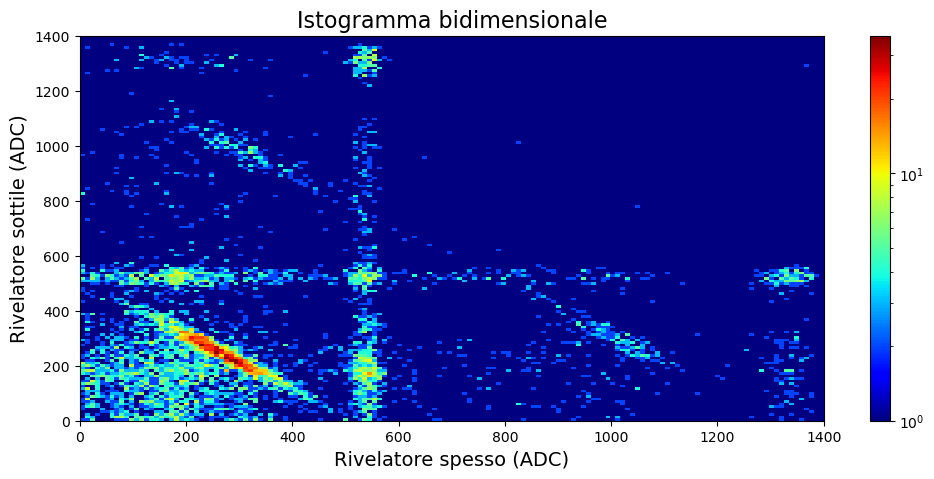

In [90]:
import copy 

# Esistono problemi con i pixels zero: li risolvo 
my_cmap = copy.copy(mpl.cm.jet) # copy the default cmap
my_cmap.set_bad(my_cmap(0))

fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.set_title("Istogramma bidimensionale", fontsize=16)

myPlot = ax.hist2d(dati1, dati2, bins = (150, 150), range = ((0, 1400), (0, 1400)),  
                    norm = mpl.colors.LogNorm(), cmap = my_cmap)

ax.set_xlabel("Rivelatore spesso (ADC)", fontsize = 14)
ax.set_ylabel("Rivelatore sottile (ADC)", fontsize = 14)

fig.colorbar(myPlot[3], ax = ax)



if Export:
    plt.savefig("../RELAZIONE/FIGURE/istogramma-2d.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

Il significato di questo plot vi sarà sicuramente più chiaro dalla teoria vista a lezione e dall'esperienza relativa in laboratorio.
Senza la pretesa di essere esaustivo, dalla mia relazione:
<blockquote>
Si possono distinguere due bande verticali/orizzontali
in corrispondenza dei picchi fotoelettrici a 511 keV e 1274 keV: il primo
corrisponde al picco di annichilazione, mentre il secondo al fotone emesso dal
decadimento della sorgente. Non si nota un significativo addensamento in prossimità
dell’intersezione a 511 keV in quanto la sorgente era posta davanti ai
due rivelatori, mentre i due fotoni di annichilazione vengono emessi in direzioni
opposte: non risulta quindi possibile rivelare nei due rivelatori i due fotoni emessi
dall’annichilazione, e quando entrambi i rivelatori hanno rivelato un fotone da
511 keV non può che essere un evento casuale, dato dalla rivelazione di un fotone
ciascuno proveniente da due annichilazioni differenti.    
    
Le due bande diagonali rappresentano la situazione
in cui un fotone all’interno di un rivelatore ceda parte della sua energia per
effetto Compton e il fotone Compton, di bassa energia, ceda la rimanente energia
all’altro rivelatore: in questo caso tutta l’energia è stata ceduta, ma ai due
rivelatori vengono di volta in volta ceduti differenti valori.
    
Sotto la diagonale a 511 keV si può ben distinguere il Compton continuum.
Si osservi in particolare come le bande diagonali non raggiungano mai gli assi:
questo si verifica poiché il massimo trasferimento di energia mediante effetto
Compton non coincide col picco fotoelettrico, ed infatti negli spettri la spalla
Compton si trova sempre prima del corrispondente picco fotoelettrico.
</blockquote>



Talvolta può essere comodo (soprattutto per sovrapporre due istogrammi bidimensionali, nel cui caso servirebbero "4 coordinate") costruire un "boxplot", ovvero un istogramma 2D, dove l'informazione sul numero di conteggi non è codificata nel colore ma nella larghezza del marker. In questo senso, utilizzando differenti colori si possono sovrapporre più istogrammi bidimensionali.

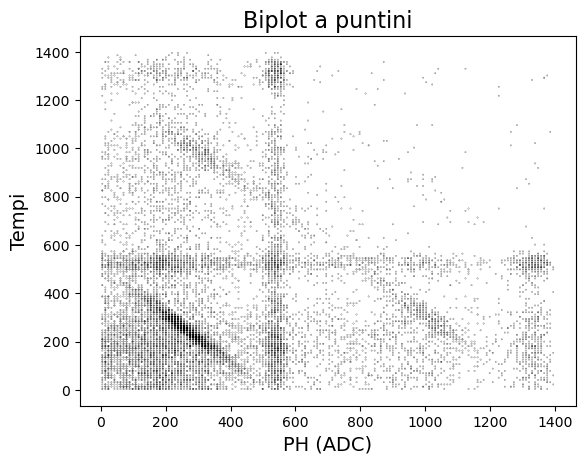

In [91]:
# Creo la mappa di punti da plottare
myGrid = np.meshgrid(myPlot[1][:-1] + (myPlot[1][1]-myPlot[1][0])/2, 
                      myPlot[2][:-1] + (myPlot[2][1]-myPlot[2][0])/2)

z1 = myPlot[0].T.flatten(order = "C")
x1 = myGrid[0].flatten(order = "C")
y1 = myGrid[1].flatten(order = "C")



# Effettuo il plot
fig, ax = plt.subplots()
fig.subplots_adjust(wspace = .4)
ax.scatter(x1, y1, color = "k", alpha = 1, marker = ".",
            s = .1 * z1,)

    
ax.set_xlabel("PH (ADC)", fontsize = 14)
ax.set_ylabel("Tempi", fontsize = 14)
ax.set_title(f"Biplot a puntini", fontsize = 16)
    
 

if Export: 
    plt.savefig(f"../LATEX/FIGURE/plot-lab/biplot.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show() 

Un'altra cosa utile può essere di tracciare delle **curve di livello**, ovvero delle curve che uniscono punti alla stessa quota. Anche questa operazione può essere fatta comodamente sfruttando `plt.contour`, oppure `plt.contourf` per colorare tra le curve di livello.


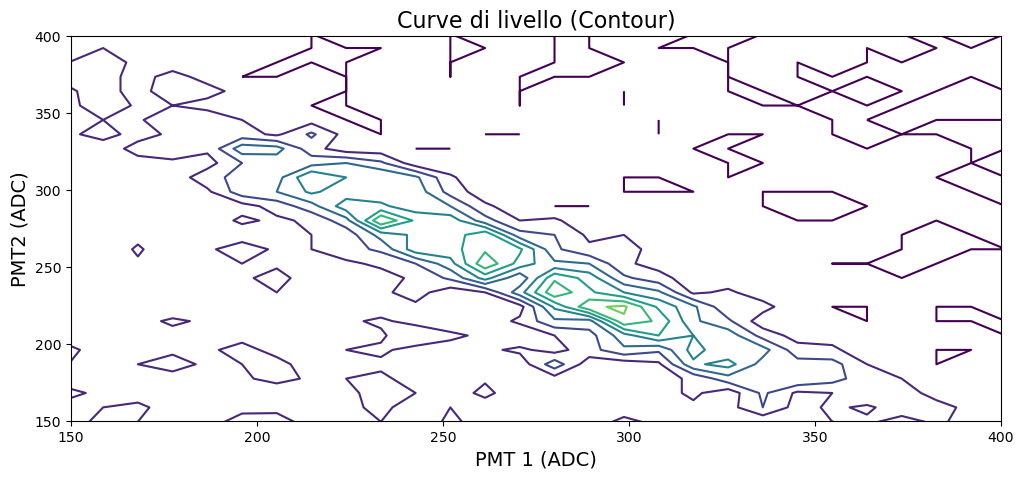

In [92]:

# Trovo i centri dei bin dell'istogramma bidimensionale
xcentr = myPlot[1][:-1] + myPlot[1][1] - myPlot[1][0]
ycentr = myPlot[2][:-1] + myPlot[2][1] - myPlot[2][0]


fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.set_title("Curve di livello (Contour)", fontsize=16)

ax.set_xlabel("PMT 1 (ADC)", fontsize = 14)
ax.set_ylabel("PMT2 (ADC)", fontsize = 14)




myContour = ax.contour(*np.meshgrid(xcentr, ycentr, indexing = "ij"), 
                       myPlot[0], levels = range(0,50,5))

ax.set_xlim((150, 400))
ax.set_ylim((150, 400))


plt.show()

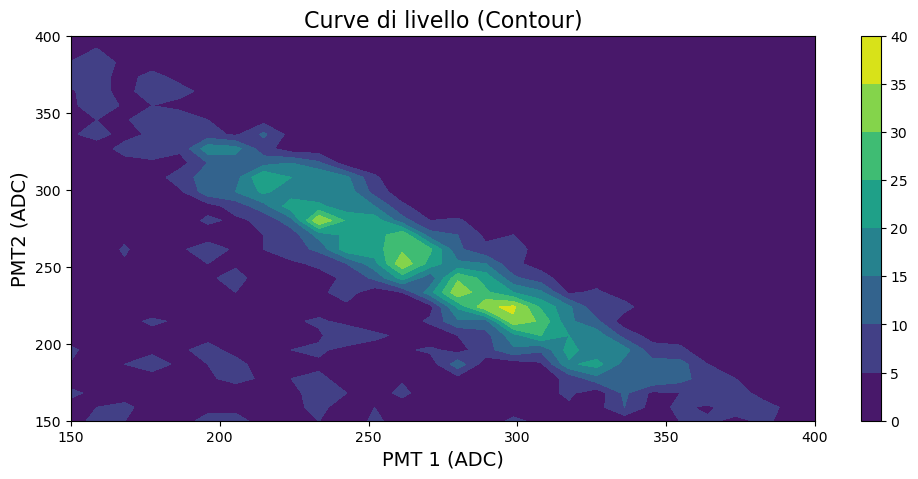

In [93]:
fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.set_title("Curve di livello (Contour)", fontsize=16)

ax.set_xlabel("PMT 1 (ADC)", fontsize = 14)
ax.set_ylabel("PMT2 (ADC)", fontsize = 14)




myContour = ax.contourf(*np.meshgrid(xcentr, ycentr, indexing = "ij"), 
                       myPlot[0], levels = range(0,45,5))

ax.set_xlim((150, 400))
ax.set_ylim((150, 400))

fig.colorbar(myContour, ax = ax)


plt.show()

# Appendice A: l'importanza di guardare i dati

[Questi dati](https://www.autodesk.com/research/publications/same-stats-different-graphs) hanno la particolarità di avere alcuni indici statistici uguali fino alla seconda cifra decimale (media x/y, std x/y e indice di correlazione di Pearson). Questo semplice esempio vuole mettere in luce l'importanza di guardare i dati, non limitarsi a farseli riassumere da qualche indice statistico

In [94]:
dat = np.loadtxt(".\DatasaurusDozen-wide.tsv", dtype = float, delimiter = "\t", skiprows = 2)
dat.shape


(142, 26)

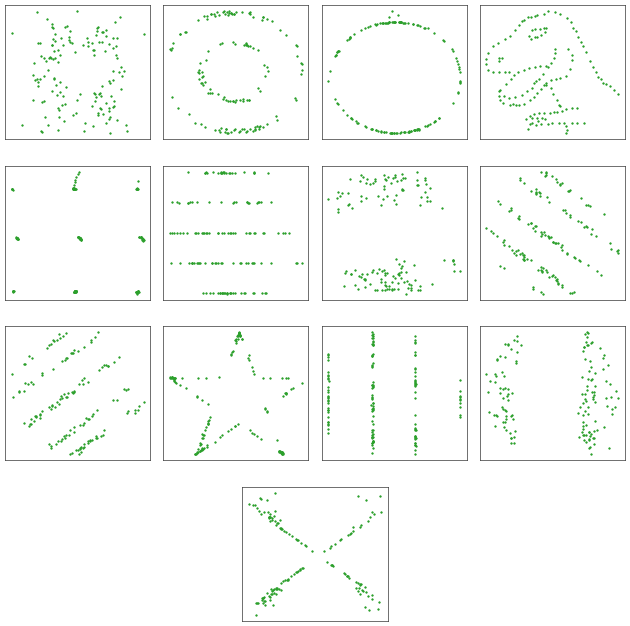

In [95]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16,16), dpi = 50) 
gs=gridspec.GridSpec(nrows=4, ncols=8, hspace=.2, wspace=.2)

ax = []
for i in range(12): pass
ax.append(fig.add_subplot(gs[0,0:2]))
ax.append(fig.add_subplot(gs[0,2:4]))
ax.append(fig.add_subplot(gs[0,4:6]))
ax.append(fig.add_subplot(gs[0,6:8]))

ax.append(fig.add_subplot(gs[1,0:2]))
ax.append(fig.add_subplot(gs[1,2:4]))
ax.append(fig.add_subplot(gs[1,4:6]))
ax.append(fig.add_subplot(gs[1,6:8]))

ax.append(fig.add_subplot(gs[2,0:2]))
ax.append(fig.add_subplot(gs[2,2:4]))
ax.append(fig.add_subplot(gs[2,4:6]))
ax.append(fig.add_subplot(gs[2,6:8]))

ax.append(fig.add_subplot(gs[3,3:5]))




ss = dat.shape
for i in range(len(ax)):
    ax[i].scatter(dat[:,2*i], dat[:,2*i+1], s = 5, c = "tab:green")
    
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
    
plt.show()
    


In [96]:
from scipy.stats import pearsonr

for i in range(13):
    print(f"Dataset: {i}\t mean x: {np.mean(dat[:,2*i]):.4f}\t mean y: {np.mean(dat[:,2*i+1]):.4f}\t std x: {np.std(dat[:,2*i]):.4f}\t std y: {np.std(dat[:,2*i+1]):.4f}\t coor Pearson: {pearsonr(dat[:,2*i], dat[:,2*i+1])}") 

Dataset: 0	 mean x: 54.2661	 mean y: 47.8347	 std x: 16.7107	 std y: 26.8447	 coor Pearson: PearsonRResult(statistic=-0.0641283521547448, pvalue=0.44832881989437734)
Dataset: 1	 mean x: 54.2687	 mean y: 47.8308	 std x: 16.7101	 std y: 26.8407	 coor Pearson: PearsonRResult(statistic=-0.06858639425794844, pvalue=0.4173467255448403)
Dataset: 2	 mean x: 54.2673	 mean y: 47.8377	 std x: 16.7009	 std y: 26.8350	 coor Pearson: PearsonRResult(statistic=-0.06834335645012025, pvalue=0.41900290275449925)
Dataset: 3	 mean x: 54.2633	 mean y: 47.8323	 std x: 16.7060	 std y: 26.8404	 coor Pearson: PearsonRResult(statistic=-0.06447185270095164, pvalue=0.44589659802470283)
Dataset: 4	 mean x: 54.2603	 mean y: 47.8398	 std x: 16.7086	 std y: 26.8352	 coor Pearson: PearsonRResult(statistic=-0.06034144199353861, pvalue=0.4756315608671551)
Dataset: 5	 mean x: 54.2614	 mean y: 47.8303	 std x: 16.7068	 std y: 26.8448	 coor Pearson: PearsonRResult(statistic=-0.06171483795667776, pvalue=0.4656268147329649)
Da

# Appendice B: il problema della funzione spigolosa
Talvolta, per esempio quando si effettua il fit gaussiano di un picco, può accadere di avere pochi punti a disposizione. Ricalcando quanto descritto nel [tutorial del prof. Mascagna](https://vmascagn.web.cern.ch/vmascagn/LABO_2020/tutorial_spettroscopia_1_ed2021.html), generiamo un esempio di dati e vediamo come approcciare il problema

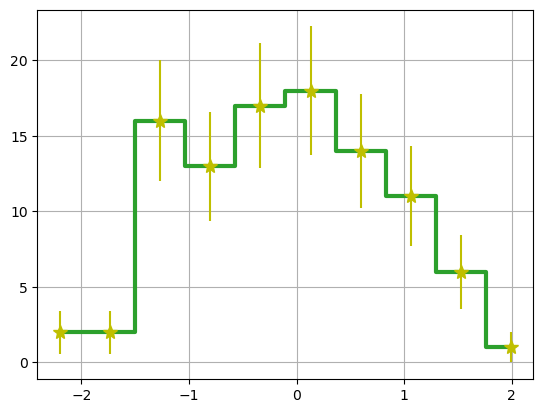

In [97]:
dati_casuali = np.random.normal(0,1,100)

h, bins = np.histogram(dati_casuali, bins = 10)
binc = bins[:-1] + (bins[1] - bins[0])/2

fig, ax = plt.subplots()

ax.plot(binc, h, ds = "steps-mid", c = "tab:green", lw = 3)
ax.errorbar(binc, h, yerr = np.sqrt(h), fmt = "*y", ms = 10)
ax.grid()

plt.show()

Proviamo ora ad eseguire il fit con la gaussiana

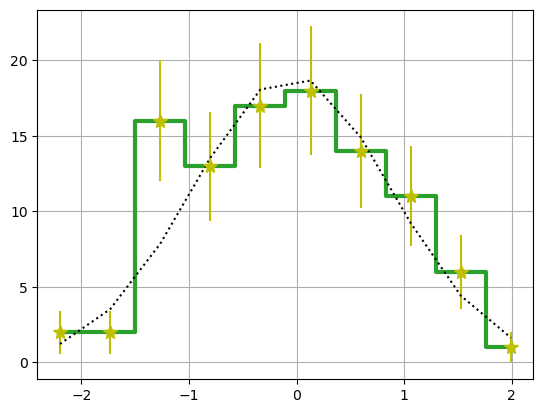

In [98]:
popt, pcov = curve_fit(gauss, binc, h, sigma = np.sqrt(h))

fig, ax = plt.subplots()

ax.plot(binc, h, ds = "steps-mid", c = "tab:green", lw = 3)
ax.errorbar(binc, h, yerr = np.sqrt(h), fmt = "*y", ms = 10)
ax.plot(binc, gauss(binc, *popt), ls = ":", c = "k")
ax.grid()

plt.show()

Per risolvere il problema creiamo un vettore "più denso", che abbia i medesimi estremi, ma con più punti in mezzo, in modo tale che la funzione venga disegnata più smussata. Tale problema in linea teorica l'abbiamo già incontrato con la retta di calibrazione ma, trattandosi di una retta, l'avere pochi punti in mezzo non ha alcuna rilevanza: bastano infatti due punti per definire una retta nello spazio.

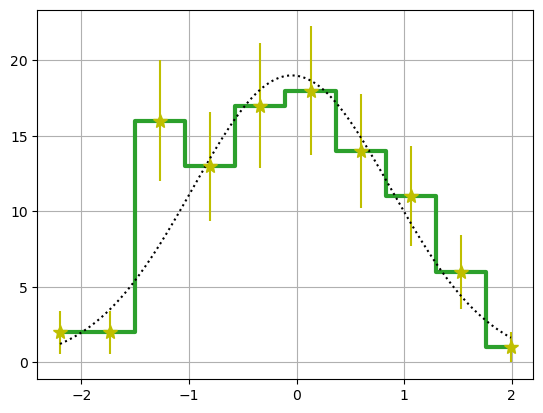

In [99]:
xDenso = np.linspace(binc[0], binc[-1], num = 1000)


fig, ax = plt.subplots()

ax.plot(binc, h, ds = "steps-mid", c = "tab:green", lw = 3)
ax.errorbar(binc, h, yerr = np.sqrt(h), fmt = "*y", ms = 10)
ax.plot(xDenso, gauss(xDenso, *popt), ls = ":", c = "k")
ax.grid()

plt.show()